# IMDb Movie Data Analysis

#### Author: Ziqi (Katie) Chen

## Introduction

In this report, I analyzed IMDb movie data between 2000 and 2020 using Exploratory Data Analysis and Visualization. In particular, I answered the following questions:

* What genres are most popular each year? Do people like certain genres over time?
* What type of movie receive higher rating?
* Which genre is most profitable? What genres are associated with higher budgets?
* Which genre has the biggest return on investment (ROI)?

## Data Source

There are two datasets that I used in this analysis:
* IMDb movie data (scraped from [IMDb website](https://www.imdb.com/))
* Kaggle movie data (csv file from [Kaggle Movie Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset))

The movie data that I scraped from IMDb was filtered by year from 2000 to 2020. Each year I picked 400 movies by descending voting count, so there are total 8400 movies in the dataset. However, there is no budget information when the data was scraped from the IMDb website. I then used the budget information from Kaggle movie data and merged it to the IMDb dataset so that I had all important information.

These are columns from the dataset that I want:
* IMDb id
* Movie title
* Released year
* Duration (min)
* Genre (one movie can have multiple genres)
* Rating (out of 10)
* Vote Count
* Budget
* Domestic gross
* Worldwide gross

## Data Cleaning

First we merged two datasets by movie id and selected columns that we need.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
import warnings
warnings.filterwarnings('ignore')

In [2]:
# These are dataframes that we want to merge
imdb_df = pd.read_csv("data/imdb_USmovie_data.csv")
tmdb_df = pd.read_csv("data/movies_metadata.csv")

# Merge dataframes, choose columns, rename column names
movie_df = imdb_df.merge(tmdb_df, on='imdb_id', how='left')
movies_df = movie_df[['imdb_id','title_x','year','duration','genre','rating','vote_count_x','budget','gross','revenue']].copy()
movies_df.rename(columns={'gross':'domestic_gross','revenue':'worldwide_gross','title_x':'title','vote_count_x':'vote_count'}, inplace=True)
movies_df.head()

,imdb_id,title,year,duration,genre,rating,vote_count,budget,domestic_gross,worldwide_gross
0,tt0172495,Gladiator,2000,155.0,"['Action, Adventure, Drama']",8.5,1329019,103000000,187705427.0,457640427.0
1,tt0209144,Memento,2000,113.0,"['Mystery, Thriller']",8.4,1116360,9000000,25544867.0,39723096.0
2,tt0208092,Snatch,2000,102.0,"['Comedy, Crime']",8.3,776147,10000000,30328156.0,83557872.0
3,tt0180093,Requiem for a Dream,2000,102.0,['Drama'],8.3,760451,4500000,3635482.0,7390108.0
4,tt0120903,X-Men,2000,104.0,"['Action, Adventure, Sci-Fi']",7.4,567551,75000000,157299717.0,296339527.0


We checked if columns have correct data types.

In [3]:
movies_df.dtypes

imdb_id             object
title               object
year                 int64
duration           float64
genre               object
rating             float64
vote_count           int64
budget              object
domestic_gross     float64
worldwide_gross    float64
dtype: object

It looks like **year**, **genre** and **budget** have incorrect data types. We then converted the type of **year** to string, **genre** to list and **budget** to float.

In [4]:
# convert the type of year to string, type of budget to float
movies_df[['year']] = movies_df[['year']].astype(str)
movies_df[['budget']] = movies_df[['budget']].astype(float)

# convert the type of genre from string to list
genre_fix = []
for item in movies_df['genre']:
    genre_list = []
    for i in item.split(','):
        genre_list.append(''.join(j for j in i if j.isalnum()))
    genre_fix.append(genre_list)
movies_df[['genre']] = genre_fix

# explde genre column
movies_df = movies_df.explode('genre')

Now we check if there is any missing value in the dataset.

In [5]:
movies_df.isnull().sum()

imdb_id               0
title                 0
year                  0
duration              4
genre                 0
rating                0
vote_count            0
budget             4406
domestic_gross     7565
worldwide_gross    4406
dtype: int64

We can see that there are missing values in **budget**, **domestic gross** and **worldwide gross**. However, we would not delete any data until we perform revenue analysis. Right now we still need all data for analysis.

## Data Analysis

### What genres are popular?

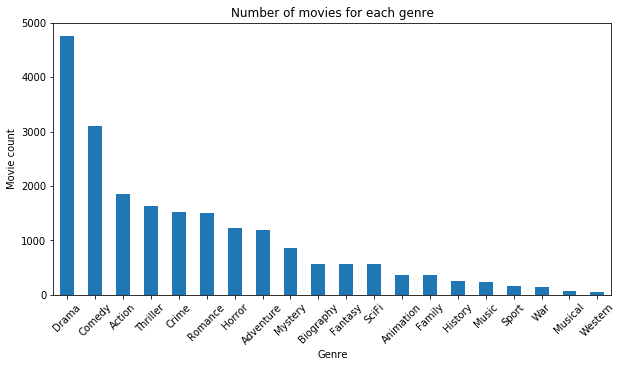

In [6]:
movies_df['genre'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of movies for each genre',
                                      xlabel='Genre', ylabel='Movie count')
# rotate x axis label with 45 degrees
plt.xticks(rotation=45)
plt.show()

It looks like the number of Drama movies are the most, which indicates **Drama** is the most popular genre, followed by **Comedy**, **Action** and **Thriller**. **Western** is the least popular genre since there are very few Western movies. We will break down movie counts by year to study how the genre popularity changes over time.

### How does movie genre popularity change over time?

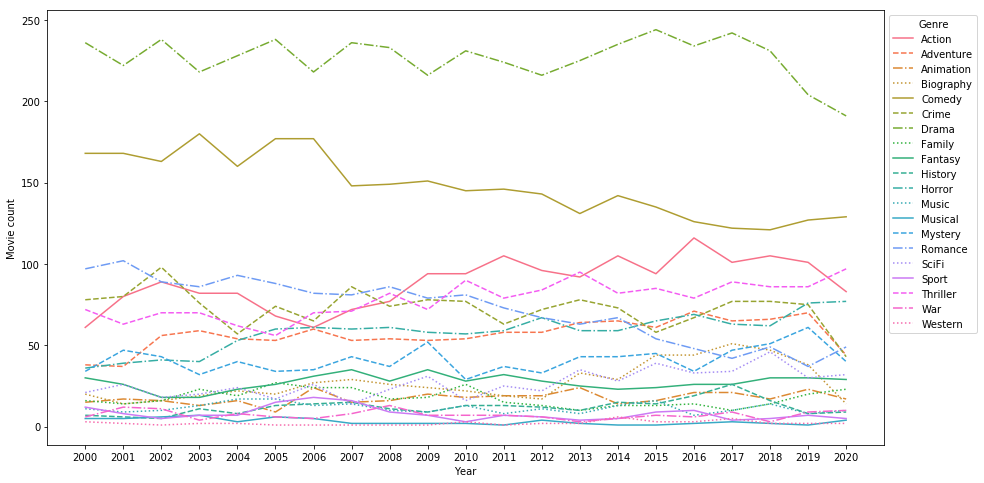

In [25]:
# create a dataframe with counts by grouping year and genre
genre_count_year = movies_df.groupby(['year','genre']).size().reset_index(name='counts')
# get all genres in the dataframe
genre = genre_count_year['genre'].unique()
# choose colors for 20 genres
num_colors = 20
colors = sns.color_palette('husl', n_colors=num_colors)
# choose linestyle to better distinguish lines
line_styles = ['solid','dashed','dashdot','dotted']
num_styles = len(line_styles)
fig, ax = plt.subplots(1)
# set figure size
fig.set_size_inches(15,8)

for i in range(num_colors):
    data = genre_count_year[genre_count_year['genre']==genre[i]]
    lines = ax.plot(data['year'], data['counts'], label=genre[i])
    lines[0].set_color(colors[i])
    lines[0].set_linestyle(line_styles[i%num_styles])
plt.xlabel('Year')
plt.ylabel('Movie count')
# move legend outside of the plot
plt.legend(title = 'Genre', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- **Drama** is still the most popular genre all the time but the number of Drama movies has decreased since 2017.  
- The number of **Comedy** movies is the second largest but it has decreased since 2006.
- There were more Romance movies in early 2000s, but **Action** and **Thriller** movies have become more popular since 2009.  
- There are very few **Musical** and **Western** movies each year.

### Movie rating distribution by genre from 2000 to 2020

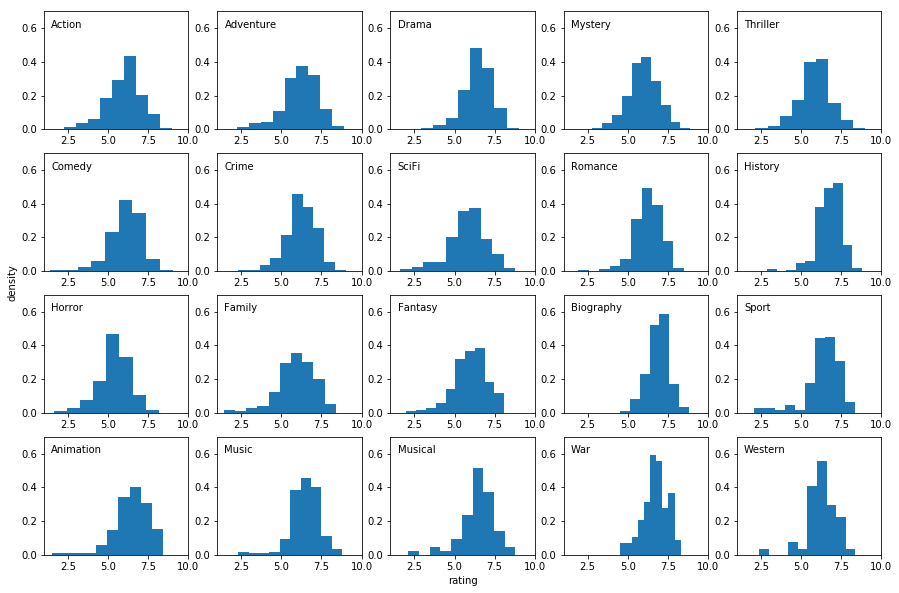

In [74]:
fig, ax = plt.subplots(4,5)
# make ax an 1D array
ax = ax.ravel()
# set the figure size
fig.set_size_inches(15,10)
# add a big axis, hide the frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

genre = movies_df['genre'].unique()
for i, j in enumerate(ax):
    df = movies_df[movies_df['genre']==genre[i]]
    j.hist(df['rating'], density=True)
    # add text for showing genre
    j.annotate(genre[i], xy=(0.05,0.86), xycoords='axes fraction')

plt.setp(ax, xlim=(1,10), ylim=(0,0.7))
plt.xlabel('rating')
plt.ylabel('density')
plt.show()

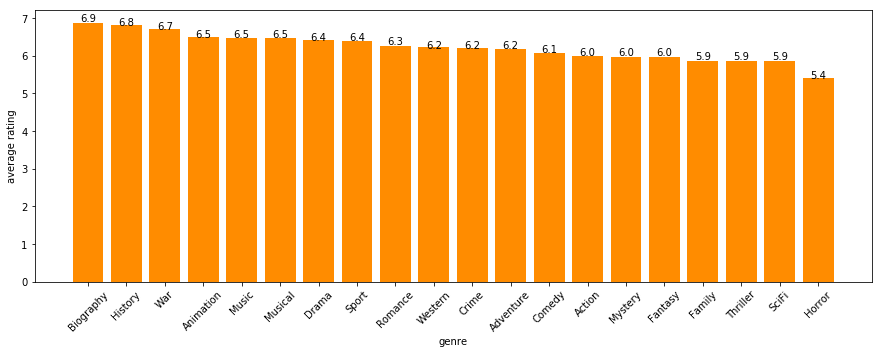

In [9]:
# dataframe with genre and average rating
rate_avg = movies_df.groupby('genre')['rating'].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15,5))
plt.bar(rate_avg['genre'], rate_avg['rating'], color='darkorange')
for index, data in enumerate(round(rate_avg['rating'],1)):
    plt.text(x=index, y=data, s=str(data), ha='center')
plt.xticks(rotation=45)
plt.xlabel('genre')
plt.ylabel('average rating')
plt.show()

We can see that the rating distribution of each genre is slightly left-skewed. The majority of movies in each genre have rating from 5 to 7. Most movies with **History**, **Biography** and **War** genres have higher rating which is above 6 and very few of them have lower rating.  

**Biography** movies have the highest average rating which is 6.9, followed by **History** and **War** which have average rating 6.8 and 6.7. **Horrer** movies receive the lowest average rating which is 5.4.  

Even though there are not many **History**, **War** and **Musical** movies each year, these movies tend to receive higher rating compared to other genres.

### Which genre is most profitable? 

One of factors that determine the success of a movie is revenue. Knowing what type of movie is most profitable helps movie investors make business decisions. In this section we will explore budget and revenue for each genre and factors that affect movie revenue.

As we mentioned earlier, budget, domestic gross and worldwide gross columns in this dataset have null values. To make the result accurate, first we need to remove these null values.

In [78]:
# remove rows with NA values from budget, domestic gross and worldwide gross columns
revenue_df = movies_df.dropna(axis=0, subset=['budget','domestic_gross','worldwide_gross'])
# remove rows with 0 from budget, domestic gross and worldwide gross columns
revenue_df = revenue_df[revenue_df['budget'] != 0]
revenue_df = revenue_df[revenue_df['domestic_gross'] != 0]
revenue_df = revenue_df[revenue_df['worldwide_gross'] != 0]
# create new column for domestic profit
revenue_df['domestic_profit'] = revenue_df['domestic_gross'] - revenue_df['budget']
# create new column for worldwide profit
revenue_df['worldwide_profit'] = revenue_df['worldwide_gross'] - revenue_df['budget']
# drop rows that domestic gross is greater than worldwide gross
refine_df = revenue_df.drop(revenue_df[revenue_df['domestic_gross']>revenue_df['worldwide_gross']].index)
# drop rows that budget is less than 10000
new_revenue_df = refine_df.drop(refine_df[refine_df['budget']<10000].index)
# drop rows that domestic gross is less than 100000
new_revenue_df = new_revenue_df.drop(new_revenue_df[new_revenue_df['domestic_gross']<100000].index)
# fix the budget for movie Live by Night to 65 millions
new_revenue_df.loc[new_revenue_df['title'] == 'Live by Night', 'budget'] = 65000000

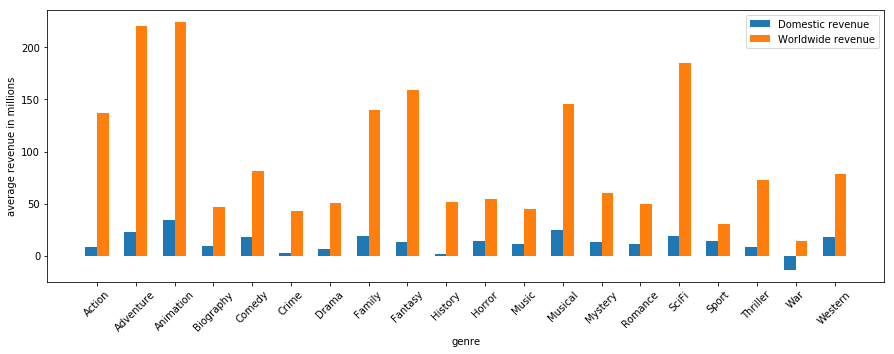

In [81]:
# dataframe with genre and average domestic profit, sort by genre
dome_profit_avg = new_revenue_df.groupby('genre')['domestic_profit'].mean().reset_index().sort_values('genre')
# dataframe with genre and average worldwide profit, sort by genre
world_profit_avg = new_revenue_df.groupby('genre')['worldwide_profit'].mean().reset_index().sort_values('genre')


plt.figure(figsize=(15,5))
# number of pairs of bar
N = 20
# position of bars on x axis
ind = np.arange(N)
# width of a bar
width = 0.3

plt.bar(ind, round(dome_profit_avg['domestic_profit']/1000000,2), width, label='Domestic revenue')
plt.bar(ind+width, round(world_profit_avg['worldwide_profit']/1000000,2), width, label='Worldwide revenue')
plt.xticks(ind+width/2, dome_profit_avg['genre'], rotation=45)
plt.xlabel('genre')
plt.ylabel('average revenue in millions')
plt.legend(loc='best')
plt.show()

We can see that **Animation**, **Musical** and **Adventure** movies have greater domestic revenue than other genres. **War** movies have negative domestic revenue. This may explain why there are very few War movies in the market.  

**Animation** and **Adventure** movies also have most worldwide revenue, followed by **SciFi** and **Fantasy** movies. **War** movies have the lowest worldwide revenue.

### Which genre is associated with higher budget?

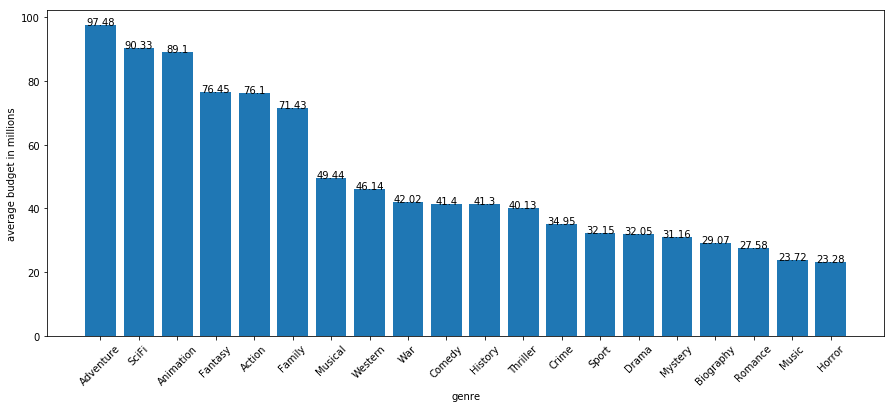

In [82]:
budget_avg = new_revenue_df.groupby('genre')['budget'].mean().reset_index().sort_values('budget', ascending=False)

plt.figure(figsize=(15,6))
plt.bar(budget_avg['genre'], round(budget_avg['budget']/1000000,2))
for index, data in enumerate(round(budget_avg['budget']/1000000,2)):
    plt.text(x=index, y=data, s=str(data), ha='center')
plt.xticks(rotation=45)
plt.xlabel('genre')
plt.ylabel('average budget in millions')
plt.show()

From the barplot we see that **Adventure**, **SciFi** and **Animation** movies have higher budgets. **Horror** and **Music** movies have the lowest budgets.  

We notice that **War**, **History** and **Crime** movies have the average domestic revenue below \\$2 million but their budgets are between \\$33 million to \\$40 million. This is not a good sign for movie investors to invest in these types of movies.  

By looking at the average budget and revenue for each genre, it is still hard to conclude what type of movie is worth to invest in as some types of movie with high revenue often have high budgets, such as **Adventure** and **Animation** movies. Therefore, we need to look at the return on investment (ROI) for each genre to determine what genre has the best return.

### Which genre has the biggest return on investment (ROI)?

Return on investment (ROI) is a measure of the efficiency of an investment. It is calculated as profit divided by budget. Here we used worldwide revenue to calculate ROI.

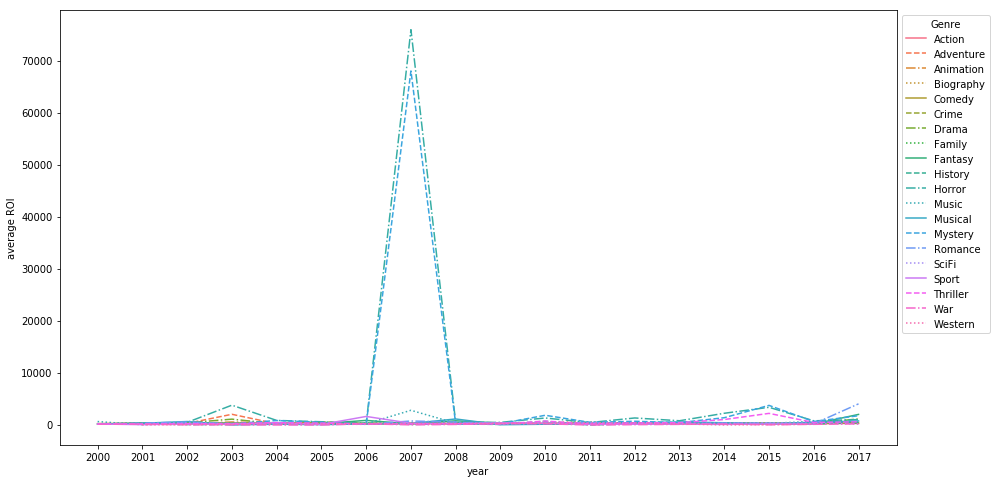

In [83]:
# create a new column for ROI
new_revenue_df['roi'] = round(new_revenue_df['worldwide_profit']/new_revenue_df['budget']*100,2)
# create a dataframe with average ROI by grouping year and genre
year_genre_roi = new_revenue_df.groupby(['year','genre'])['roi'].mean().reset_index(name='roi_avg')
# all genres in the dataframe
genre = year_genre_roi['genre'].unique()
# choose colors for 20 genres
num_colors = 20
colors = sns.color_palette('husl', n_colors=num_colors)
# choose linestyle to better distinguish lines
line_styles = ['solid','dashed','dashdot','dotted']
num_styles = len(line_styles)
fig, ax = plt.subplots(1)
# set figure size
fig.set_size_inches(15,8)

for i in range(num_colors):
    data = year_genre_roi[year_genre_roi['genre']==genre[i]]
    lines = ax.plot(data['year'], data['roi_avg'], label=genre[i])
    lines[0].set_color(colors[i])
    lines[0].set_linestyle(line_styles[i%num_styles])

plt.xlabel('year')
plt.ylabel('average ROI')
# move legend outside of the plot
plt.legend(title = 'Genre', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

The plot shows that there is an unusual peak in 2007, and it happens to both Horror and Mystery genres. This is an indication of outliers, which some movies might have very low budgets but huge revenue. I removed these outliers in order to get accurate result for each genre.

In [84]:
new_revenue_df[new_revenue_df['year']=='2007'].sort_values('roi',ascending=False).head()

,imdb_id,title,year,duration,genre,rating,vote_count,budget,domestic_gross,worldwide_gross,domestic_profit,worldwide_profit,roi
2839,tt1179904,Paranormal Activity,2007,86.0,Mystery,6.3,219805,15000.0,107918810.0,193355800.0,107903810.0,193340800.0,1288938.67
2839,tt1179904,Paranormal Activity,2007,86.0,Horror,6.3,219805,15000.0,107918810.0,193355800.0,107903810.0,193340800.0,1288938.67
2873,tt0907657,Once,2007,86.0,Romance,7.8,110141,160000.0,9439923.0,20710513.0,9279923.0,20550513.0,12844.07
2873,tt0907657,Once,2007,86.0,Music,7.8,110141,160000.0,9439923.0,20710513.0,9279923.0,20550513.0,12844.07
2873,tt0907657,Once,2007,86.0,Drama,7.8,110141,160000.0,9439923.0,20710513.0,9279923.0,20550513.0,12844.07


We can see that the movie **Paranormal Activity** in 2007 had a budget of \\$15,000 and worldwide gross of \\$193,340,800 for a return of 1,288,938.67%, which the average ROI will not reflect the true insight if I include it. The genres for this movie are Horror and Mystery, that is why there is a peak in the plot above.  

After removing this outlier, the plot looks like this:

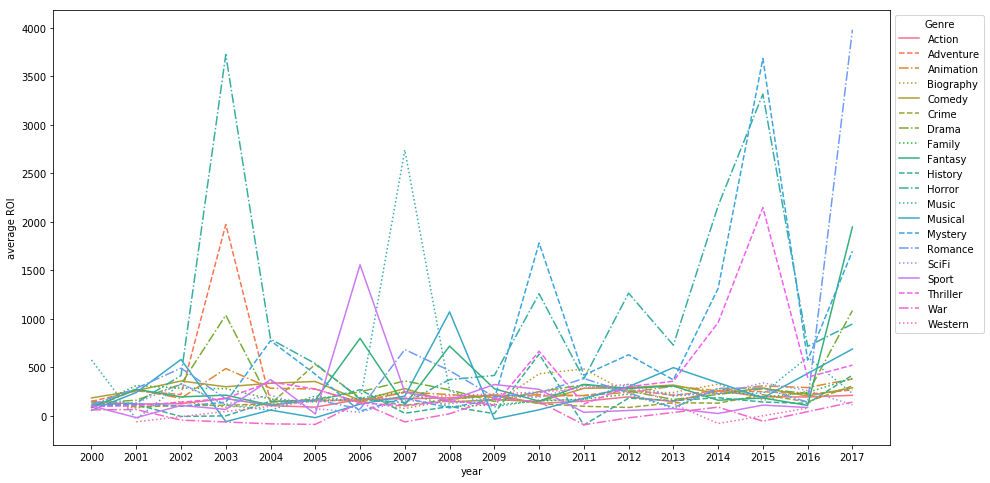

In [85]:
# remove "Paranormal Activity" movie from the dataset
updated_revenue_df = new_revenue_df[new_revenue_df['title']!='Paranormal Activity']
# create a dataframe with average ROI by grouping year and genre
year_genre_roi = updated_revenue_df.groupby(['year','genre'])['roi'].mean().reset_index(name='roi_avg')
# all genres in the dataframe
genre = year_genre_roi['genre'].unique()
# choose colors for 20 genres
num_colors = 20
colors = sns.color_palette('husl', n_colors=num_colors)
# choose linestyle to better distinguish lines
line_styles = ['solid','dashed','dashdot','dotted']
num_styles = len(line_styles)
fig, ax = plt.subplots(1)
# set figure size
fig.set_size_inches(15,8)

for i in range(num_colors):
    data = year_genre_roi[year_genre_roi['genre']==genre[i]]
    lines = ax.plot(data['year'], data['roi_avg'], label=genre[i])
    lines[0].set_color(colors[i])
    lines[0].set_linestyle(line_styles[i%num_styles])

plt.xlabel('year')
plt.ylabel('average ROI')
# move legend outside of the plot
plt.legend(title = 'Genre', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- **Horror** movies had very large ROI in 2003 and 2015, and overall this type of movie had a large ROI all the time.
- **Mystery** movies did not have ROI as large as Horror movies, but this genre also had good ROI.
- **Thriller**, **Fantasy**, **Romance** movies had ROI under 500% each year before 2016, but their ROI has increased a lot in 2017.
- Most of the time **War** and **Western** movies had the lowest ROI.

## Conclusions

Results that we take away with this report are:

- Drama, Comedy and Action genres are the most popular genre. War, Western and Musical genres are not favored by the majority.
- While the number of Comedy movies is the second largest, it has decreased over time. 
- Most movies have rating between 5 and 7. History, Biography and War movies tend to have higher rating. Horror movies have the lowest average rating.
- Animation and Adventure movies are most profitable. War movies made the least revenue.
- Adventure, Animation and SciFi movies have large budgets while they brought huge revenue. Horror and Music movies have the lowest budgets. War, History and Crime movies made way less money compared to their large budgets.
- Horror and Mystery movies have the best ROI. Thriller, Fantasy and Romance movies are also worth to invest in. War and Western movies have the lowest ROI compared to other genres.